In [1]:
#=
using Pkg; 
packages = ["Knet", "AutoGrad", "Random", "Test", "MLDatasets", "CUDA", "Plots", "GR","Statistics",
            "IterTools", "StatsBase", "DSP", "Images", "DelimitedFiles", "MultivariateStats", "PyPlot", "PyCall"];
Pkg.add(packages);
=#

In [31]:
include("../src/modules/TUM69.jl")
include("../src/modules/Preprocess.jl")
include("../src/modules/Network.jl")
include("../src/modules/Utils.jl")

## Third party packages
using Knet: KnetArray, adam, relu, minibatch
using AutoGrad, Knet, CUDA


## Handwritten modules
using .TUM69: load_accel_data   # Data reading
using .Preprocess: process_accel_signal # Preprocessing on the data
using .Network: GCN, train_summarize!, accuracy4, nll4, GenericMLP # Construction of custom network
using .Utils: notify

In [32]:
AutoGrad.set_gc_function(AutoGrad.default_gc)

default_gc (generic function with 1 method)

In [33]:
# Trick from Deniz Hoca to deal with this issue: https://github.com/denizyuret/Knet.jl/issues/524
#=
using Knet
function Knet.KnetArray(x::CuArray{T,N}) where {T,N}
    p = Base.bitcast(Knet.Cptr, pointer(x))
    k = Knet.KnetPtr(p, sizeof(x), Int(CUDA.device().handle), x)
    KnetArray{T,N}(k, size(x))
end
=#

In [34]:
# Array type setting for GPU usage
a_type() = (CUDA.functional() ? KnetArray{Float32} : Array{Float32})

a_type (generic function with 1 method)

In [35]:
# CUDA information
GC.gc(true)
CUDA.device()

CuDevice(0): Tesla V100-SXM2-32GB

In [36]:
path = CUDA.functional() ? "/userfiles/vaydingul20/data/trial" : "./../data/trial" # path of the main data
DATA_PATH = isdir(path) && path

"/userfiles/vaydingul20/data/trial"

In [37]:
X_train, y_train,
X_test, y_test, 
material_dict = @time load_accel_data(DATA_PATH; mode = "baseline");  # Data loading routine

Train accel data is being loaded!
Test accel data is being loaded!
  0.681278 seconds (4.51 M allocations: 147.138 MiB, 2.11% gc time)


In [38]:
println("X_train = ", summary(X_train))
println("y_train = ", summary(y_train))
println("X_test  = ", summary(X_test))
println("y_test  = ", summary(y_test))
println("material_dict = ", summary(material_dict))

X_train = 3-element Array{Array{Float32,1},1}
y_train = 3-element Array{Int8,1}
X_test  = 3-element Array{Array{Float32,1},1}
y_test  = 3-element Array{Int8,1}
material_dict = Dict{String,Int8} with 3 entries


In [39]:
#Preprocessing on the acceleration data
@time X_train_modified, y_train_modified = process_accel_signal(X_train, y_train);
@time X_test_modified, y_test_modified = process_accel_signal(X_test, y_test);

  0.060965 seconds (388 allocations: 30.432 MiB)
  0.059381 seconds (388 allocations: 30.432 MiB, 12.68% gc time)


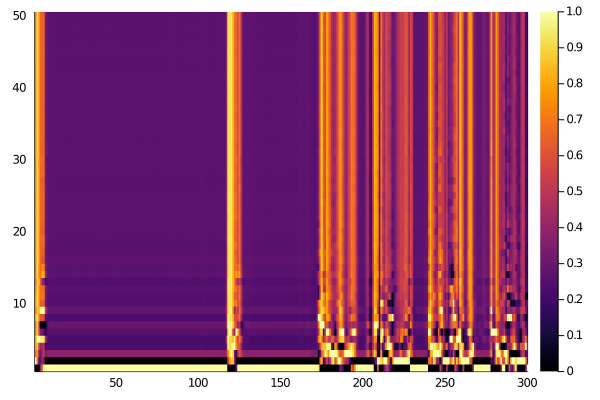

In [40]:
using Plots
heatmap(X_train_modified[:,:,1,1])

In [41]:
println("X_train = ", summary(X_train_modified))
println("y_train = ", summary(y_train_modified))
println("X_test  = ", summary(X_test_modified))
println("y_test  = ", summary(y_test_modified))
println("material_dict = ", summary(material_dict))

X_train = 50×300×1×24 Array{Float32,4}
y_train = 24-element Array{Int8,1}
X_test  = 50×300×1×24 Array{Float32,4}
y_test  = 24-element Array{Int8,1}
material_dict = Dict{String,Int8} with 3 entries


In [42]:
# Some constants that will be used in the network model
MINIBATCH_SIZE = 10
INPUT_SIZE = size(X_test_modified)[1:3]
OUTPUT_SIZE = size(collect(keys(material_dict)))[1];

In [43]:
# Minibatching
dtrn = minibatch(X_train_modified, y_train_modified, MINIBATCH_SIZE; xtype = a_type(), shuffle = true)
dtst = minibatch(X_test_modified, y_test_modified, MINIBATCH_SIZE; xtype = a_type(), shuffle = true);

In [44]:
#=
model = GCN(INPUT_SIZE, OUTPUT_SIZE, 
       [(25, 150, 1 , relu, 0.0, (1, 1), (1, 1), (2, 2), false)]; 
    hidden=[10], optimizer_type = sgd, lr = 0.15, loss_fnc=nll, accuracy_fnc = accuracy, atype=a_type())
=#

In [45]:

model = GCN(INPUT_SIZE, OUTPUT_SIZE, 
       [(3, 3, 50 , relu, 0.0, (1, 1), (1, 1), (2, 2), true),
        (3, 3, 100, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (3, 3, 150, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (3, 3, 200, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (4, 12,400, relu, 0.5, (1, 0), (1, 1), (1, 1), false),
        (1, 1, 250, relu, 0.5, (0, 0), (1, 1), (1, 1), false),
        (1, 1, OUTPUT_SIZE , relu, 0.5, (0, 0), (1, 1), (1, 1), false),
        ]; 
    hidden=[], optimizer_type = adam, lr = 1e-4, loss_fnc=nll4, accuracy_fnc = accuracy4, atype=a_type())


GCN((Main.Network.Conv(P(KnetArray{Float32,4}(3,3,1,50)), P(KnetArray{Float32,4}(1,1,50,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), true, KnetArray{Float32,N} where N), Main.Network.Conv(P(KnetArray{Float32,4}(3,3,50,100)), P(KnetArray{Float32,4}(1,1,100,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), false, KnetArray{Float32,N} where N), Main.Network.Conv(P(KnetArray{Float32,4}(3,3,100,150)), P(KnetArray{Float32,4}(1,1,150,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), false, KnetArray{Float32,N} where N), Main.Network.Conv(P(KnetArray{Float32,4}(3,3,150,200)), P(KnetArray{Float32,4}(1,1,200,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), false, KnetArray{Float32,N} where N), Main.Network.Conv(P(KnetArray{Float32,4}(4,12,200,400)), P(KnetArray{Float32,4}(1,1,400,1)), Knet.Ops20.relu, 0, (1, 0), (1, 1), (1, 1), false, KnetArray{Float32,N} where N), Main.Network.Conv(P(KnetArray{Float32,4}(1,1,400,250)), P(KnetArray{Float32,4}(1,1,250,1)), Knet.Ops20.relu, 0, (0, 0), (1, 1), (1

In [46]:
aa = KnetArray(randn(4,4,4,4));


In [52]:
function LR_norm(x; o...)
    
        _, _, _, batch_size = size(x)
         
         for k in 1:batch_size
             
             x[:, :, :, k] = atype(mapslices(x -> _LR_norm(x; o...), Array(x[:, :, :, k]), dims = 3))
             
         end
         
         return x
         
     end



    function _LR_norm(x; k = 2, n = 5, alpha = 0.0001, beta = 0.75, atype = Array)
    
        nc = length(x)
        x_ = atype(zeros(nc))
        for i in 1:nc
            
            _lower = convert(Int, floor(max(1., i - n/2)))
            _upper = convert(Int, floor(min(nc, i + n/2)))
            _sum = sum(x[_lower:_upper].^2)
            x_[i] = x[i] ./ ((k .+ alpha .* _sum).^beta)
        end
        
        return x_
    end

_LR_norm (generic function with 1 method)

In [53]:
LR_norm(aa)

LoadError: UndefVarError: atype not defined

In [17]:
model(dtst)

LoadError: MethodError: no method matching mapslices(::Main.Network.var"#16#17"{Base.Iterators.Pairs{Symbol,UnionAll,Tuple{Symbol},NamedTuple{(:atype,),Tuple{UnionAll}}}}, ::KnetArray{Float32,3}; dims=3)
Closest candidates are:
  mapslices(::Any, !Matched::AbstractArray; dims) at abstractarray.jl:2061

In [18]:
# Training routine
# Currently, the model is not working due to the issue mentioned in: https://github.com/denizyuret/Knet.jl/issues/624#
# As soon as it is solved, I hope the model will be accurately working.
res = train_summarize!(model, dtrn, dtst; 
                       train_type = "epoch", progress_bar = true ,fig = true, info = true, 
                       epoch = 100, conv_epoch = 50, max_conv_cycle = 20)


Stacktrace:
 [1] LR_norm(::AutoGrad.Result{KnetArray{Float32,4}}; o::Base.Iterators.Pairs{Symbol,UnionAll,Tuple{Symbol},NamedTuple{(:atype,),Tuple{UnionAll}}}) at /scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/Network.jl:335
 [2] (::Main.Network.Conv)(::KnetArray{Float32,4}) at /scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/Network.jl:231
 [3] (::GCN)(::KnetArray{Float32,4}) at /scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/Network.jl:304
 [4] (::GCN)(::KnetArray{Float32,4}, ::Array{Int8,1}) at /scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/Network.jl:315
 [5] (::Knet.Train20.var"#27#28"{Knet.Train20.Minimize{IterTools.NCycle{Knet.Train20.Data{Tuple{KnetArray{Float32,N} where N,Array{Int8,N} where N}}}},Tuple{KnetArray{Float32,4},Array{Int8,1}}})() at /kuacc/users/vaydingul20/.julia/packages/AutoGrad/VFrAv/src/core.jl:205
 [6] differentiate(::Function; o::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple

LoadError: MethodError: no method matching mapslices(::Main.Network.var"#16#17"{Base.Iterators.Pairs{Symbol,UnionAll,Tuple{Symbol},NamedTuple{(:atype,),Tuple{UnionAll}}}}, ::AutoGrad.Result{KnetArray{Float32,3}}; dims=3)
Closest candidates are:
  mapslices(::Any, !Matched::AbstractArray; dims) at abstractarray.jl:2061

In [19]:
notify("OK!")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     3    0     0  100     3      0      2  0:00:01  0:00:01 --:--:--     2

{}

100     5  100     2  100     3      1      1  0:00:03  0:00:01  0:00:02     3


Process(`curl https://notify.run/fnx04zT7QmOlLLa6 -d OK!`, ProcessExited(0))